<a href="https://colab.research.google.com/github/eRuaro/Food-vision/blob/master/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# tesla t4 best for mixed precision
# !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6a93b64d-3d48-32ef-69fd-638d6cdc4725)


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

import tensorflow as tf 
print(tf.__version__)

2.7.0


## Helper Functions

In [ ]:
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
  # Read in the image
    img = tf.io.read_file(filename)
  # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
  # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
    # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):     
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.
    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.
    Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).
    
    Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.
    Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

  # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
  # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

  # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
  # Import the target image and preprocess it
    img = load_and_prep_image(filename)

  # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.
    Stores log files with the filepath:
        "dir_name/experiment_name/current_datetime/"
    Args:
        dir_name: target directory to store TensorBoard log files
        experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

  # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

  # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
    """
    Unzips filename into the current working directory.
    Args:
        filename (str): a filepath to a target zip folder to be unzipped.
    """
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
        dir_path (str): target directory
    
    Returns:
        A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
  # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

## Getting dataset from tensorflow datsets

Why use TensorFlow Datasets?

    Load data already in Tensors
    Practice on well established datasets
    Experiment with differet data loading techniques (like we're going to use in this notebook)
    Experiment with new TensorFlow features quickly (such as mixed precision training)

Why not use TensorFlow Datasets?

    The datasets are static (they don't change, like your real-world datasets would)
    Might not be suited for your particular problem (but great for experimenting)


In [ ]:
import tensorflow_datasets as tfds 

In [ ]:
# list available datasets
datasets_list = tfds.list_builders() # gets available datasets
print('food101' in datasets_list)

True


In [ ]:
# loading dataset
(train_data, test_data), ds_info = tfds.load(
    name='food101', #target name
    split=['train', 'validation'], # what splits of data should we get (not all have test, train, split)
    shuffle_files=True, # shuffle files on download
    as_supervised=True, # download data in tuple format (sample, label)
    with_info=True # include dataset metadata? If so returns (data, data_info)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteT9A0LA/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteT9A0LA/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring dataset

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our tfds.load() method above, data samples come in the tuple format structure (data, label) or in our case (image_tensor, label).

In [ ]:
# what does one sample in training set look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (341, 512, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 98
    Class name (str form): tiramisu
    


Because we set the shuffle_files=True parameter in our tfds.load() method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example (512, 342, 3) and (512, 512, 3) (height, width, color_channels).

In [ ]:
image

<tf.Tensor: shape=(341, 512, 3), dtype=uint8, numpy=
array([[[  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0],
        ...,
        [  0,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  3,   3,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   5,   1]],

       ...,

       [[143,  75,  10],
        [149,  81,  16],
        [150,  85,  19],
        ...,
        [162,  88,  25],
        [150,  79,  17],
        [135,  65,   5]],

       [[144,  76,  11],
        [152,  84,  19],
        [145,  80,  16],
        ...,
        [126,  60,  12],
        [111,  50,   3],
        [ 95,  37,   0]],

       [[145,  77,  14],
        [150,  82,  19],
        [139,  74,  10],
        ...,
        [ 89,  35,   

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type unit8.

### Plotting image from tensorflow datasets

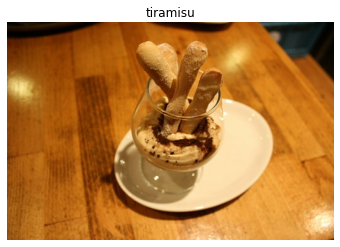

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

## Preprocessing data

### Creating preprocessing functions

Our data is currently:

    In uint8 data type
    Comprised of all differnet sized tensors (different sized images)
    Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

    In float32 data type
    Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
    Scaled (values between 0 & 1), also called normalized


In [ ]:
def preprocess_img(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [0 3 0]
  [0 4 0]
  [0 4 0]]

 [[2 2 0]
  [2 2 0]
  [3 3 1]
  ...
  [1 3 0]
  [0 4 0]
  [0 4 0]]]...,
Shape: (341, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[2.         2.         0.        ]
  [2.947226   2.947226   0.947226  ]
  [4.         5.         0.        ]
  ...
  [1.         3.         0.        ]
  [0.01865775 2.757497   0.        ]
  [0.         4.         0.        ]]

 [[4.3504467  5.133929   0.7834822 ]
  [4.566964   5.3504467  1.        ]
  [4.783482   5.783482   0.7834822 ]
  ...
  [1.         3.         0.        ]
  [0.7989506  2.7989507  0.        ]
  [0.         4.2798424  0.2798424 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


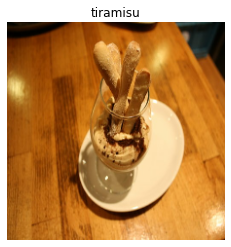

In [ ]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

### Batch and prepare datasets

we're going to be using:

    map() - maps a predefined function to a target dataset (e.g. preprocess_img() to our image tensors)
    shuffle() - randomly shuffles the elements of a target dataset up buffer_size (ideally, the buffer_size is equal to the size of the dataset, however, this may have implications on memory)
    batch() - turns elements of a target dataset into batches (size defined by parameter batch_size)
    prefetch() - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
    Extra: cache() - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB o

`Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> Prefetched Dataset`

In [ ]:
# map preprocessing function to training data and parallelize
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing function to test data and parallelize
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle test and turn it into batches and prefetch it
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

🔑 Note: You can get away without calling the prefetch() method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to prefecth().

## Create modelling callbacks

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    montior='val_accuracy', # save model weights with best val_accuracy
    save_best_only=True, # only save the best weights
    save_weights_only=True, # only save model weights (not whole model)
    verbose=1 # dont print out whether or not model is being saved
)

## Setup mixed precision training

In [ ]:
# turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16') # set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Building feature extraction model

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

    Build a feature extraction model (replace the top few layers of a pretrained model)
    Train for a few epochs with lower layers frozen
    Fine-tune if necessary with multiple layers unfrozen


In [ ]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing 

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False # freeze base model layers

#create functional model
inputs = layers.Input(shape=input_shape, name='input_layer', dtype=tf.float16)
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x)  # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

## Fitting feature extraction model

In [ ]:
history_101_food_classes_feature_extract = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[create_tensorboard_callback(
        'training_logs',
        'efficientnetb0_101_classes_all_data_feature_extract'),
        model_checkpoint
    ],
)

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220123-081957
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 1.8244 - accuracy: 0.5554
Epoch 00001: val_loss improved from inf to 1.23266, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 198s 77ms/step - loss: 1.8244 - accuracy: 0.5554 - val_loss: 1.2327 - val_accuracy: 0.6769
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2941 - accuracy: 0.6665
Epoch 00002: val_loss improved from 1.23266 to 1.12737, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 180s 75ms/step - loss: 1.2941 - accuracy: 0.6665 - val_loss: 1.1274 - val_accuracy: 0.6973
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1433 - accuracy: 0.7014
Epoch 00003: val_loss improved from 1.12737 to 1.09674, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 180s 75ms/step - loss: 1.1432 - accuracy: 0.7014 - val_loss: 1.0967 - val_accuracy: 0.7047


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 53s 65ms/step - loss: 1.0847 - accuracy: 0.7069


[1.084722638130188, 0.7068910598754883]

## Load and evaluate checkpoint weights

In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
# !ls model_checkpoints/

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
# Where are our checkpoints stored?
checkpoint_path

'model_checkpoints/cp.ckpt'

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [ ]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evalaute cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)
results_cloned_model_with_loaded_weights

790/790 [==============================] - 52s 64ms/step - loss: 1.7009 - accuracy: 0.5551


[1.7008575201034546, 0.5551286935806274]

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all() # check if all elements in array are close

False

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False 

### Saving model to Google Drive 

In [ ]:
# Create save path to drive 
save_dir = "drive/MyDrive/Tensorflow-course/Food-vision/models/07_efficientnetb0_feature_extract_model_mixed_precision/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow-course/Food-vision/models/07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow-course/Food-vision/models/07_efficientnetb0_feature_extract_model_mixed_precision/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False 

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 55s 66ms/step - loss: 1.0847 - accuracy: 0.7069


[1.0847234725952148, 0.7068910598754883]

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

True

## Preparing model for fine-tuning

In [ ]:
loaded_gs_model = loaded_saved_model

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float16 <Policy "float16">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_1 True float32 <Policy "mixed_float16">
normalization_1 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "m

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220123-094552
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 337s 142ms/step - loss: 0.0116 - accuracy: 0.9986 - val_loss: 1.2315 - val_accuracy: 0.7963 - lr: 2.0000e-05
Epoch 2/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.0056 - accuracy: 0.9994 - val_loss: 1.3774 - val_accuracy: 0.7929 - lr: 2.0000e-05
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9992
Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 339s 142ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 1.4327 - val_accuracy: 0.7876 - lr: 2.0000e-05
Epoch 4/100
2368/2368 [==============================] - 340s 143ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 1.4270 - val_accuracy: 0.7945 - lr: 4.0000e-06


In [ ]:
# # Save model to Google Drive (optional)
save_dir = "drive/MyDrive/Tensorflow-course/Food-vision/models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/"
os.makedirs(save_dir)
loaded_gs_model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow-course/Food-vision/models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Tensorflow-course/Food-vision/models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 55s 67ms/step - loss: 1.3996 - accuracy: 0.8000


[1.3995575904846191, 0.800000011920929]

## View training results on TensorBoard

In [ ]:
# !tensorboard dev upload --logdir ./training_logs \
#   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
#   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=SFXiONQevc6hWWquqCE4Vxp6m84MSW&prompt=consent&access_type=offli

In [ ]:
# View past TensorBoard experiments
# !tensorboard dev list

https://tensorboard.dev/experiment/H4quLRGYQf67U0GcQ0C90g/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   H4quLRGYQf67U0GcQ0C90g
	Created              2022-01-23 10:37:25 (3 minutes ago)
	Updated              2022-01-23 10:37:28 (3 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              72
	Tensor bytes         0
	Binary object bytes  3373905
Total: 1 experiment(s)


In [ ]:
# Delete past TensorBoard experiments
# !tensorboard dev delete --experiment_id H4quLRGYQf67U0GcQ0C90g
# Example
# !tensorboard dev delete --experiment_id OAE6KXizQZKQxDiqI3cnUQ

Deleted experiment H4quLRGYQf67U0GcQ0C90g.


## Custom Data

In [6]:
# Load model previously saved above
import tensorflow as tf

# save_dir = "drive/MyDrive/Tensorflow-course/Food-vision/models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/"
# model = tf.keras.models.load_model(save_dir)

def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
  # Read in the image
    img = tf.io.read_file(filename)
  # Decode it into a tensor
    img = tf.image.decode_jpeg(img)
  # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
    # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img


import matplotlib.pyplot as plt

def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
  # Import the target image and preprocess it
    img = load_and_prep_image(filename)

  # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

In [2]:
class_predictions = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']

In [12]:


url = 'https://www.mashed.com/img/gallery/you-should-never-fold-pizza-slices-heres-why/intro-1602105889.jpg'
def load_and_predict_image_net(url, model, img_shape=224, class_names=class_predictions):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).
    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
  # Read in the image
    img_path = tf.keras.utils.get_file(origin=url)

    img = tf.keras.utils.load_img(
        img_path, target_size=(img_shape, img_shape)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #create a batch

    pred = model.predict(img_array)
    score = tf.nn.softmax(pred[0])

    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    print( "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(pred_class)

In [8]:
# url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
import numpy as np 
load_and_predict_image_net(url)

This image most likely belongs to pizza with a 2.65 percent confidence.
pizza


In [9]:
steak = 'https://hips.hearstapps.com/delish/assets/18/08/1519155106-flank-steak-horizontal.jpg'
load_and_predict_image_net(steak)

385024/370760 [===============================] - 0s 0us/step
This image most likely belongs to steak with a 2.61 percent confidence.
steak


In [10]:
model.save("food-vision-model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [8]:
load_model = tf.keras.models.load_model("food-vision-model.h5")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [16]:
import numpy as np
steak = 'cdn.foodism.co.uk/gallery/5c51835487f2a.jpeg'
load_and_predict_image_net(steak, model=load_model)

This image most likely belongs to pizza with a 2.65 percent confidence.
pizza


In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file 
from tensorflow.keras.utils import load_img 
from tensorflow.keras.utils import img_to_array
from tensorflow import expand_dims
from tensorflow.nn import softmax
from numpy import argmax
from numpy import max

model = load_model("food-vision-model.h5")

def get_net_image_prediction(image_link: str):
    img_path = get_file(
        origin = image_link
    )
    img = load_img(
        img_path, 
        target_size = (224, 224)
    )

    img_array = img_to_array(img)
    img_array = expand_dims(img_array, 0)

    pred = model.predict(img_array)
    score = softmax(pred[0])

    class_prediction = class_predictions[argmax(score)]
    model_score = round(max(score) * 100, 2)

    return {
        "model_prediction_class": class_prediction,
        "model_prediction_score": model_score,
        "score": max(score) * 100
    }

get_net_image_prediction("https://cdn.foodism.co.uk/gallery/5c51835487f2a.jpeg")

{'model_prediction_class': 'pizza',
 'model_prediction_score': 2.65,
 'score': 2.6463450863957405}

In [12]:
model.summary() == load_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-tra

True